In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Functions

## Logistic Regression

In [4]:
#--------------------LR FUNCTIONS--------------------#
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.maximum(epsilon, y_pred)
    y_pred = np.minimum(1 - epsilon, y_pred)
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def gradient_descent(X, y, learning_rate, num_epochs):
    num_samples, num_features = X.shape
    weights = np.zeros(num_features)
    bias = 0
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        z = np.dot(X, weights) + bias
        y_pred = sigmoid(z)

        training_loss = np.mean(log_loss(y, y_pred))
        training_losses.append(training_loss)

        dw = (1/num_samples) * np.dot(X.T, (y_pred - y))
        db = (1/num_samples) * np.sum(y_pred - y)

        weights -= learning_rate * dw
        bias -= learning_rate * db
        z_val = np.dot(X_val, weights) + bias
        y_pred_val = sigmoid(z_val)
        validation_loss = np.mean(log_loss(y_val, y_pred_val))
        validation_losses.append(validation_loss)

    return weights, bias, training_losses, validation_losses

def classify(X, weights, threshold=0.5):
    z = np.dot(X, weights)
    y_pred = sigmoid(z)
    return (y_pred >= threshold).astype(int)

def evaluate(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return precision, recall, f_measure, accuracy



## ROC and AUC

In [ ]:
#--------------------ROC AND FUNCTIONS--------------------#
def calc_TPR(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    # print(f"tp are {tp}")
    fn = np.sum((y_true == 1) & (y_pred == 0))
    # print(f"fn are {fn}")
    
    return tp / (tp + fn)
    

def calc_FPR(y_true, y_pred):
    fp = np.sum((y_true == 0) & (y_pred == 1))
    # print(f"fp are {fp}")
    tn = np.sum((y_true == 0) & (y_pred == 0))
    # print(f"tn are {tn}")
    
    return fp / (fp + tn)


def make_roc_df(X_inp, weights_inp, y_true_inp):
    pred_dict = {"threshold": [],
                 "tpr": [],
                 "fpr": [],
                 "accuracy": [],
                 "f1-measure": [],
                 "precision": [],
                 "recall": []
                }
    
    # thresholds = [0.1, 0.4, 0.7, 0.9]
    thresholds = [i/100 for i in range(0, 100+1)] # 0 to 1, by 0.01 steps
    # print(thresholds)
    for thr in thresholds:
        pred_dict["threshold"].append(thr)
        # print(f"threshold is {thr}")
        y_pred_calc = classify(X = X_inp, 
                               weights = weights_inp, 
                               threshold = thr)
        
        tpr = calc_TPR(y_true_inp, y_pred_calc)
        pred_dict["tpr"].append(tpr)
        # print(f"TPR is {tpr}")
        fpr = calc_FPR(y_true_inp, y_pred_calc)
        pred_dict["fpr"].append(fpr)
        # print(f"FPR is {fpr}")
        precision, recall, f_measure, accuracy = evaluate(y_true_inp, y_pred_calc)
        pred_dict["accuracy"].append(accuracy)
        pred_dict["f1-measure"].append(f_measure)
        pred_dict["precision"].append(precision)
        pred_dict["recall"].append(recall)
        # print()
    
    return pd.DataFrame(pred_dict)

def calc_AUC(df_roc_inp):
    
    df_roc_inp_sorted = df_roc_inp.sort_values(["fpr"])
    
    auc = np.trapz(y=df_roc_inp_sorted["tpr"], 
                   x=df_roc_inp_sorted["fpr"],
                  )
    
    return auc

def roc_curves_LR(X_train_inp, y_train_inp, X_val_inp, y_val_inp, learning_rate_lst, num_epochs):
    
    df_graph_lst = []
    auc_dict = {"learning_rate": [],
                "AUC": []
               }
    
    for l_rate in learning_rate_lst:
        weights, bias, training_losses, validation_losses = gradient_descent(X_train_inp, 
                                                                             y_train_inp, 
                                                                             l_rate, 
                                                                             num_epochs)
        
        calculate_weight_impact(X_train_inp, weights, l_rate)
        df_graph_inp = make_roc_df(X_val_inp, weights, y_val_inp)
        df_graph_inp["learning_rate"] = l_rate
                
        df_graph_lst.append(df_graph_inp)
        
        auc_dict["learning_rate"].append(l_rate)
        auc_dict["AUC"].append(calc_AUC(df_graph_inp))
        
    df_graph = pd.concat(df_graph_lst)
    df_graph.to_csv('table_of_error_metrics.csv')
    df_auc = pd.DataFrame(auc_dict)
    
    fig = px.line(df_graph,
                  title=f"ROC for Logistic Regression with varied Learning Rates and {num_epochs} Epochs",
                  x="fpr",
                  y="tpr",
                  hover_data = ["threshold", "tpr", "fpr", "learning_rate"],
                  color="learning_rate",
                  template="plotly_white",
                  # markers=True,
                  width=800,
                  height=600,
                  labels={"tpr": "TPR", "fpr": "FPR", "learning_rate": "Learning Rate"}
                 )
    
    fig.show()
    
    
    
    
    
    return df_graph, df_auc, fig    

def calculate_weight_impact(X_train, weights, l_rate):
    # weights_array = np.array(list(zip))
    weights_df = pd.DataFrame({'Weight': weights})
    # print(X_train)
    # weights_df.to_csv('weights' + str(l_rate) + '.csv')
    # print(weights_df)

    weights_df['Absolute_Weight'] = weights_df['Weight'].abs()
    sorted_weights = weights_df.sort_values(by='Absolute_Weight', ascending=False)

    # Print the sorted DataFrame
    print(sorted_weights)
    sorted_weights.to_csv('weights' + str(l_rate) + '.csv')

## Cross-Validation

In [5]:
'''
Shuffle input data matrix @X and @y, splitting based on proportion to go to training data @train_size_prop.

Keeps proportion of class labels consistent across training set and validation set (to ensure validation set will contain desired proportion of class labels to verify against).
'''

def shuffle_by_class_split(X, y, train_size_prop):
    from math import ceil
    np.random.seed(seed=0)
    uniq_classes = np.unique(y)
    
    train_i = []
    val_i = []
    
    # Build list of indices where samples have given class label. Adds first 2/3 of shuffled indices to train_i, and last 1/3 to val_i.
    for label in uniq_classes:

        filt_ind = np.array(ind_where_true(y, label))

        shuffled_ind = filt_ind.copy()
        np.random.shuffle(shuffled_ind)


        train_size_last_index = ceil(train_size_prop * (len(shuffled_ind)-1))


        train_i += list(shuffled_ind[:train_size_last_index])

        val_i += list(shuffled_ind[train_size_last_index:])
    
    # Training and validation sets filtered down based on lists indices built earlier
    X_train, X_val = X[train_i], X[val_i]
    y_train, y_val = y[train_i], y[val_i]
    
    return X_train, X_val, y_train, y_val

In [6]:
###----------FUNCTIONS----------###
'''
Makes training and validation sets for input data matrix @dat into S cross-validation folds. 

Iterates S times, setting seed to value of iteration index. Divides dataset into S folds, with last fold being slightly larger and containing remainder of data due to potential rounding of indices used to slice dataset. The i-th fold is the validation set, and concatentates other folds together to form training set.

Stores arrays corresponding to training and validation X and y into a dictionary, assuming last column is y as per problem requirements.
'''
def cv_shuffle_split(dat, S):
    cv_dict = {}
    for i in range(1, S+1):

        # Shuffle data
        # np.random.seed(seed=i)
        dat_shuffled = dat.copy()
        np.random.shuffle(dat_shuffled)
        
        # Define test set fold

        fold_size = int(np.around(len(dat_shuffled) / S, 0))
        
        ## Label start and stop indices for test fold
        ind_start_val = (i-1) * fold_size


        if i != S:
            ind_end_val = i * fold_size
        else:
            ind_end_val = len(dat_shuffled)

    
        dat_val = dat_shuffled[ind_start_val:ind_end_val, :]
        
        # Define train set made up of all other folds
        pre_val_slice = dat_shuffled[:ind_start_val, :]
        post_val_slice = dat_shuffled[ind_end_val:, :]

        dat_train = np.concatenate((pre_val_slice,
                                    post_val_slice))
        
        
        
        cv_dict[i] = {"X_train_cv": dat_train[:, :-1],
                      "y_train_cv": dat_train[:, -1],
                      "X_val_cv": dat_val[:, :-1],
                      "y_val_cv": dat_val[:, -1]
                     }
    
    return cv_dict

# Get data

In [16]:
# Data is shuffled

train_path = "./pre_processing/output/training_data_resampled_encoded.csv"
val_path = "./pre_processing/output/validation_data_encoded.csv"

#train_path = "training_data_resampled_encoded.csv"
#val_path = "validation_data_encoded.csv"

bank_training = pd.read_csv(train_path)
bank_validation = pd.read_csv(val_path)

# Step 4: Standardize the features
X_train = bank_training.iloc[:, :-1].values
y_train = bank_training.iloc[:, -1].values
X_val = bank_validation.iloc[:, :-1].values
y_val = bank_validation.iloc[:, -1].values

# Add a bias to X_Train and X_val
ones_column = np.ones((X_train.shape[0], 1))
X_train = np.c_[ones_column, X_train]
ones_column = np.ones((X_val.shape[0], 1))
X_val = np.c_[ones_column, X_val]

In [28]:
dat_train = np.c_[X_train, y_train]
dat_train.shape

(48730, 83)

# Cross Validation with different learning rates

In [32]:
cv_train = cv_shuffle_split(dat_train, 5)
cv_train[1]

{'X_train_cv': array([[1., 1., 0., ..., 0., 0., 1.],
        [1., 0., 1., ..., 0., 0., 1.],
        [1., 0., 1., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.]]),
 'y_train_cv': array([0., 0., 1., ..., 1., 1., 1.]),
 'X_val_cv': array([[1., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 1., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 1., 0., ..., 0., 0., 1.],
        [1., 1., 0., ..., 0., 0., 1.]]),
 'y_val_cv': array([0., 1., 0., ..., 0., 0., 0.])}

In [38]:
def cv_scores(cv_dict, params_dict):
    
    # Dictionary to keep track of performance
    performance_dict = {"learning_rate": [],
                        "fold": [],
                        "auc": []}
    
    # Iterate over CV folds
    for l_rate in params_dict["learning_rate"]:
        for fold in cv_dict:
            # Calculate weight using training set of fold
            weights, bias, training_loss, validation_losses = gradient_descent(cv_dict[fold]["X_train_cv"],
                                                                               cv_dict[fold]["y_train_cv"],
                                                                               l_rate,
                                                                               100
                                                                              )

            # Calculate AUC of validation set for each CV fold. Uses fitted weights.
            thresholds = [i/100 for i in range(0, 100+1)] # 0 to 1, by 0.01 steps
            tpr_lst = []
            fpr_lst = []

            ## Generate ROC values for curve
            for thr in thresholds:
                y_val_pred_cv = classify(X = cv_dict[fold]["X_val_cv"],
                                         weights = weights,
                                         threshold = thr)
                tpr = calc_TPR(cv_dict[fold]["y_val_cv"], y_val_pred_cv)
                tpr_lst.append(tpr)

                for thr in thresholds:
                    y_pred_calc = np.where(y_val_pred_cv >= thr, 1, 0)



                fpr = calc_FPR(cv_dict[fold]["y_val_cv"], y_val_pred_cv)
                fpr_lst.append(fpr)

            ## Calculate area
            auc = np.abs(np.trapz(y=tpr_lst, 
                                  x=fpr_lst,
                                 )
                        )

            performance_dict["learning_rate"].append(l_rate)
            performance_dict["fold"].append(fold)
            performance_dict["auc"].append(auc)

    return pd.DataFrame(performance_dict)

In [41]:
params_dict_lr = {"learning_rate": [0.01, 0.1, 1, 10],}

df_cv_lr = cv_scores(cv_train, params_dict_lr)
df_cv_lr

,learning_rate,fold,auc
0,0.01,1,0.834817
1,0.01,2,0.841394
2,0.01,3,0.833897
3,0.01,4,0.832379
4,0.01,5,0.834303
5,0.10,1,0.878366
6,0.10,2,0.885781
7,0.10,3,0.877574
8,0.10,4,0.877473
9,0.10,5,0.879252


### Get learning rate from best AUC

In [45]:
df_cv_lr_gba = (df_cv_lr
                .groupby(["learning_rate"])
                .agg(auc_mean = ("auc", "mean"))
                .sort_values("auc_mean", ascending=False)
                .reset_index()
               )

df_cv_lr_gba

,learning_rate,auc_mean
0,1.00,0.906845
1,0.10,0.879689
2,10.00,0.868782
3,0.01,0.835358


# Best learning rate for validation

In [46]:
weights, bias, training_loss, validation_losses = gradient_descent(X_train,
                                                                   y_train,
                                                                   1,
                                                                   100
                                                                  )

In [49]:
df_roc_lr_val = make_roc_df(X_val, weights, y_val).loc[:, ["threshold", "tpr", "fpr"]]
df_roc_lr_val

<ipython-input-4-d110a210ccec>:48: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,threshold,tpr,fpr
0,0.00,1.000000,1.000000
1,0.01,1.000000,0.999918
2,0.02,1.000000,0.976935
3,0.03,1.000000,0.944349
4,0.04,0.999354,0.896249
...,...,...,...
96,0.96,0.135747,0.008126
97,0.97,0.102133,0.004925
98,0.98,0.082741,0.002627
99,0.99,0.058177,0.001642


In [50]:
df_roc_lr_val["diff"] = df_roc_lr_val["tpr"] - df_roc_lr_val["fpr"]

df_roc_lr_val.sort_values(["diff"], ascending=False)

,threshold,tpr,fpr,diff
33,0.33,0.956690,0.288188,0.668502
35,0.35,0.948287,0.280473,0.667814
34,0.34,0.951519,0.284577,0.666942
32,0.32,0.959276,0.292867,0.666409
36,0.36,0.942469,0.276205,0.666265
...,...,...,...,...
3,0.03,1.000000,0.944349,0.055651
2,0.02,1.000000,0.976935,0.023065
1,0.01,1.000000,0.999918,0.000082
0,0.00,1.000000,1.000000,0.000000


In [56]:
df_roc_lr_val.to_csv("LR_with_cv_roc_table.csv")

In [ ]:
import plotly.express as px
px.line(df_roc_lr_val,
        x="fpr",
        y="tpr",
        hover_data = ["fpr", "tpr", "threshold"]

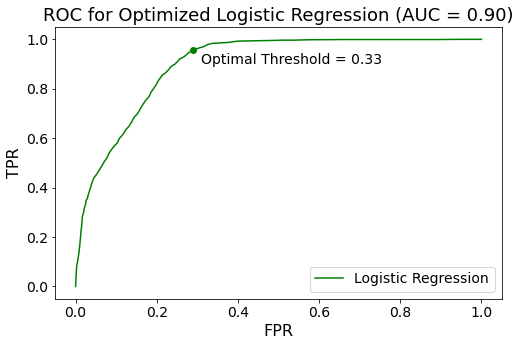

In [54]:
# Make plot of log-loss vs. epochs
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df_roc_lr_val["fpr"], df_roc_lr_val["tpr"], color="green", 
        # marker="o", 
        linestyle="solid",
        label="Logistic Regression" 
       );
# ax.plot(model_data[:, 1], model_data[:, 3], color="green", marker="o", linestyle="dashed", label="Validation Set");

ax.plot(0.288188, 0.956690, color="green", marker="o")
ax.set_xlabel("FPR", fontsize=16)
ax.set_ylabel("TPR", fontsize=16)
ax.set_title(f"ROC for Optimized Logistic Regression (AUC = 0.90)", 
             fontsize=18)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ax.legend(fontsize=14)
# ax.grid()
font = {
        # "family": "Arial",
        # "weight": "bold",
        "size": 14}

plt.text(0.31, 0.90, "Optimal Threshold = 0.33", font)
plt.show()


In [53]:
calc_AUC(df_roc_lr_val)

0.8982541665161131